# Scratch file for developing vivarium-comets

## Run COMETS from COMETSpy for just one square

In [6]:
import cometspy as c
import cobra
import matplotlib.pyplot as plt

In [9]:
# Check the cobra version
print(cobra.__version__)

0.22.1


### Create a layout for the simulation

In [3]:
# Create empty 1x1 layout
test_tube = c.layout()

# Add 11mM glucose
test_tube.set_specific_metabolite('glc__D_e', 0.011)

# Add infinite amount of oxygen
test_tube.set_specific_metabolite('o2_e', 1000)

# Add the rest of nutrients unlimited (ammonia, phosphate, water and protons)
test_tube.set_specific_metabolite('nh4_e',1000);
test_tube.set_specific_metabolite('pi_e',1000);
test_tube.set_specific_metabolite('h2o_e',1000);
test_tube.set_specific_metabolite('h_e',1000);

building empty layout model
models will need to be added with layout.add_model()


### Load a model

In [10]:
# create the model using CobraPy functionality
e_coli_cobra = cobra.test.create_test_model('textbook')
# use the loaded model to build a comets model
# Translate the cobra format into the comets format
e_coli = c.model(e_coli_cobra)

# remove the bounds from glucose import (will be set dynamically by COMETS)
# The bounds will be over written by the Michaelis-Menten kinetics
# By default the bounds are 0 and 1000, can cause problems
e_coli.change_bounds('EX_glc__D_e', -1000, 1000)
e_coli.change_bounds('EX_ac_e', -1000, 1000)

# set the model's initial biomass
# First two numbers are the x & y coordinates of the COMETS 2D grid
# COMETS uses 0 indexing, so 0 0 is the first square
e_coli.initial_pop = [0, 0, 5e-6]

# add it to the test_tube
test_tube.add_model(e_coli)

Using license file /usr/local/gurobi/gurobi.lic
Set parameter TokenServer to value sccsvc


### Set the simulation parameters

In [11]:
# Set the parameters that are different from the default
sim_params = c.params()

# Parameters of the uptake reactions
# Default values will be applied to all uptake reactions
# You can set the parameters for each model, but here we just have one model so setting for all the models is the same
sim_params.set_param('defaultVmax', 18.5)
# sim_params.set_param('defaultKm', 0.000015)
# Make Km much bigger, controls how 
sim_params.set_param('defaultKm', 0.000015)

# How many time steps in total are we running
sim_params.set_param('maxCycles', 1000)

# How long is each step
# Accuracy of the solution will depend on how big the time step is
sim_params.set_param('timeStep', 0.01)

# Size of the spatial box
# Unit is in cm
# Here we will have a volume of 1 mL
sim_params.set_param('spaceWidth', 1)

sim_params.set_param('maxSpaceBiomass', 10)

# Don't bother doing FBA where the biomass is really small
sim_params.set_param('minSpaceBiomass', 1e-11)

# Write the media so we can see how the media changes over time
sim_params.set_param('writeMediaLog', True)

### Run the simulation

In [12]:
# Define an experiment
experiment = c.comets(test_tube, sim_params)

In [13]:
experiment.run()


Running COMETS simulation ...
Done!


### Plot the results

#### Plot the biomass

Text(0, 0.5, 'Biomass (gr.)')

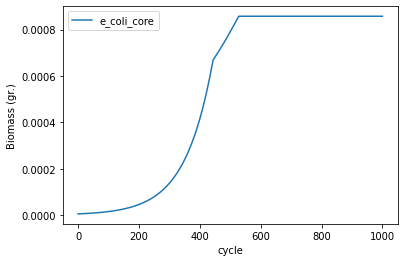

In [14]:
# Plot the biomass
ax = experiment.total_biomass.plot(x = 'cycle')
ax.set_ylabel("Biomass (gr.)")

#### Plot the metabolites

Text(0, 0.5, 'Concentration (mmol)')

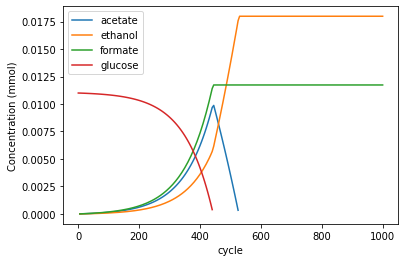

In [15]:
# Look the matbolites
# Only look at things less than 900 so that you don't see the infinite things, only look at thigs that are secreted
media = experiment.media.copy()
media = media[media.conc_mmol<900]

fig, ax = plt.subplots()
media.groupby('metabolite').plot(x='cycle', ax =ax, y='conc_mmol')
ax.legend(('acetate','ethanol', 'formate', 'glucose'))
ax.set_ylabel("Concentration (mmol)")

## Pull out the results I need for that square

I'll need:
1. Biomass
    * `experiment.total_biomass`
    * How to break out by the model?
2. Nutrients
    * `experiment.media`
    * Do I need to do .copy()
3. Diffusing biomass
    * Really don't know how to do this one

## Make a Vivarium Process

In [17]:
# Pip install to a specific location on the scc
# !pip install --target=/projectnb/cometsfba/pythonlibs/python3.8/site-packages vivarium-core

     |████████████████████████████████| 126 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.4 MB 54.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 83.8 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 70.7 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 89.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 488 kB 84.7 MB/s eta 0:00:01
     |████████████████████████████████| 43.4 MB 86.6 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 85.1 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 74.9 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 94.7 MB/s eta 0:00:01
     |████████████████████████████████| 959 kB 78.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 82.5 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 

In [7]:
import matplotlib

In [1]:
# Process, Deriver, and Composer base classes
from vivarium.core.process import Process, Deriver
from vivarium.core.composer import Composer
from vivarium.core.registry import process_registry

In [2]:
# helper functions for composition
from vivarium.core.composition import (
    simulate_process,
    process_in_experiment,
    composer_in_experiment,
    composite_in_experiment)

# other vivarium imports
from vivarium.core.engine import Engine, pp
from vivarium.library.units import units

# plotting functions
from vivarium.plots.simulation_output import (
    plot_simulation_output, plot_variables)
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology


In [3]:
class Tx(Process):
    
    defaults = {
        'ktsc': 1e-2,
        'kdeg': 1e-3}

    def __init__(self, parameters=None):
        super().__init__(parameters)
        
    def ports_schema(self):
        return {
            'DNA': {  
                'G': {
                    '_default': 10 * units.mg / units.mL,         
                    '_updater': 'accumulate',
                    '_emit': True}},
            'mRNA': {
                'C': {
                    '_default': 100 * units.mg / units.mL,
                    '_updater': 'accumulate',
                    '_emit': True}}}
    
    def next_update(self, timestep, states):
        G = states['DNA']['G']
        C = states['mRNA']['C']
        dC = (self.parameters['ktsc'] * G - self.parameters['kdeg'] * C) * timestep
        return {
            'mRNA': {
                'C': dC}}

In [8]:
store_cmap = matplotlib.cm.get_cmap('Dark2')
dna_color = matplotlib.colors.to_rgba(store_cmap(0))
rna_color = matplotlib.colors.to_rgba(store_cmap(1))
protein_color = matplotlib.colors.to_rgba(store_cmap(2))
global_color = matplotlib.colors.to_rgba(store_cmap(7))
store_colors = {
    'DNA': dna_color,
    'DNA\n(counts)': dna_color,
    'DNA\n(mg/mL)': dna_color,
    'mRNA': rna_color,
    'mRNA\n(counts)': rna_color,
    'mRNA\n(mg/mL)': rna_color,
    'Protein': protein_color,
    'Protein\n(mg/mL)': protein_color,
    'global': global_color}

In [10]:
plot_var_config = {
    'row_height': 2,
    'row_padding': 0.2,
    'column_width': 10,
    'out_dir': 'out'}

In [11]:
tx_plot_config = {
    'variables': [
        {
            'variable': ('mRNA', ('C', 'milligram / milliliter')),
            'color': store_colors['mRNA']
        }, 
        {
            'variable': ('DNA', ('G', 'milligram / milliliter')),
            'color': store_colors['DNA']
        }],
    'filename': 'tx_output.pdf',
    **plot_var_config}

In [14]:
tx_config = {'time_step': 10}
tx_sim_settings = {
    'experiment_id': 'TX'}
tx_initial_state = {
    'mRNA': {'C': 0.0 * units.mg/units.mL}}


Simulation ID: TX
Created: 09/29/2022 at 15:13:22
Completed in 0.346428 seconds
Writing out/tx_output.pdf


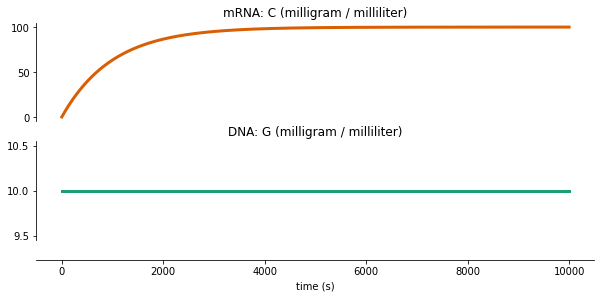

In [15]:
# initialize
tx_process = Tx(tx_config)

# make the experiment
tx_exp = process_in_experiment(
    tx_process, tx_sim_settings, tx_initial_state)

# run
tx_exp.update(10000)

# retrieve the data as a timeseries
tx_output = tx_exp.emitter.get_timeseries()

# plot
fig = plot_variables(tx_output,  **tx_plot_config)

## Run the Vivarium Process